In [1]:
import numpy as np

import sklearn
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import dendrogram  # you can use this
from scipy.spatial.distance import cdist  # fast distance matrices
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

In [2]:
def kmeans(X, k, max_iter=100):
    n, d = X.shape
    np.random.seed(42)
    centroids = X[np.random.choice(n, k, replace=False)]

    r = np.zeros(n, dtype=int)
    prev_r = np.ones(n, dtype=int)
    iteration = 0
    while iteration < max_iter and not np.array_equal(r, prev_r):
        prev_r = r.copy()
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        r = np.argmin(distances, axis=1)
        for i in range(k):
            if np.any(r == i):
                centroids[i] = X[r == i].mean(axis=0)
            else:
                centroids[i] = X[np.random.choice(n)]
        loss = np.sum((X - centroids[r])**2)
        changes = np.sum(r != prev_r)
        iteration += 1
    return centroids, r, loss

In [3]:
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
perfect_r = [1,0,1,2,2,1,2,2,2]
def test_kmeans(self):
    worked1 = False
    worked2 = False

    for _ in range(10):
        mu, r, _ = imp.kmeans(self.X, k=3)
        if (r[0]==r[1]==r[2]!=r[3] and r[3]==r[4]==r[5]!=r[6] and r[6]==r[7]==r[8]):
            worked1 = True

        # test one cluster center
        if (np.linalg.norm(mu[0] - [10.41666, 0.1666]) < 0.1 or
                np.linalg.norm(mu[1] - [10.41666, 0.1666]) < 0.1 or
                np.linalg.norm(mu[2] - [10.41666, 0.1666]) < 0.1):
            worked2 = True
        if worked1 and worked2:
            break
    if not worked1:
        raise AssertionError('test_kmeans cluster assignments are wrong.')
    if not worked2:
        raise AssertionError('test_kmeans did not find the correct cluster center.')

In [4]:
def kmeans_agglo(X, r):
    def kmeans_crit(X, r):
        unique_clusters = np.unique(r)
        centroids = np.array([X[r == cluster, :].mean(axis=0) for cluster in unique_clusters])
        loss = np.sum([np.linalg.norm(X[r == cluster, :] - centroids[i], axis=1).sum()
                       for i, cluster in enumerate(unique_clusters)])
        return loss

    n = X.shape[0]
    unique_clusters = np.unique(r)
    k = len(unique_clusters)

    R = np.zeros((k - 1, n), dtype=int)
    kmloss = np.zeros(k)
    mergeidx = np.zeros((k - 1, 2), dtype=int)

    R[0] = r
    kmloss[0] = kmeans_crit(X, r)

    current_r = r.copy()

    for step in range(1, k):
        unique_clusters = np.unique(current_r)
        num_clusters = len(unique_clusters)

        min_loss_increase = float('inf')
        merge_pair = None

        for i in range(num_clusters):
            for j in range(i + 1, num_clusters):
                cluster_i = unique_clusters[i]
                cluster_j = unique_clusters[j]

                combined_points = np.vstack([X[current_r == cluster_i, :], X[current_r == cluster_j, :]])
                combined_centroid = combined_points.mean(axis=0)

                combined_loss = np.linalg.norm(combined_points - combined_centroid, axis=1).sum()
                current_loss_i = np.linalg.norm(X[current_r == cluster_i, :] - combined_centroid, axis=1).sum()
                current_loss_j = np.linalg.norm(X[current_r == cluster_j, :] - combined_centroid, axis=1).sum()

                loss_increase = combined_loss - (current_loss_i + current_loss_j)

                if loss_increase < min_loss_increase:
                    min_loss_increase = loss_increase
                    merge_pair = (cluster_i, cluster_j)

        # Print statements for debugging
        print(f"Step {step}: Merging clusters {merge_pair} with loss increase {min_loss_increase}")

        # merge
        new_cluster_idx = np.max(current_r) + 1
        current_r[current_r == merge_pair[1]] = merge_pair[0]
        current_r[current_r == merge_pair[0]] = new_cluster_idx

        R[step - 1] = current_r
        kmloss[step] = kmloss[step - 1] + min_loss_increase
        mergeidx[step - 1] = merge_pair

    return R, kmloss, mergeidx

In [5]:
def agglo_dendro(kmloss, mergeidx):
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram
    
    k = len(kmloss)
    linkage_matrix = np.zeros((k - 1, 4))
    for i in range(k - 1):
        cluster1, cluster2 = mergeidx[i]
        linkage_matrix[i, 0] = cluster1
        linkage_matrix[i, 1] = cluster2
        linkage_matrix[i, 2] = kmloss[i + 1] - kmloss[i]
        linkage_matrix[i, 3] = i + 2
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Data points")
    plt.ylabel("Distance")
    plt.show()


In [6]:
def agglo_dendro(kmloss, mergeidx):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """

    X = np.zeros([mergeidx.shape[0], 4])
    X[:, [0, 1]] = mergeidx
    X[:, 2] = kmloss[1:]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Loss values of k-means criterion function')
    ax.set_title('Agglomerative Clustering Dendrogram', fontweight='bold', fontsize=14);
    dendrogram(X)


In [17]:
def norm_pdf(X, mu, C):
    
    # Ensure inputs are numpy arrays
    X = np.asarray(X)     # (n, d)
    n, d = X.shape       
    mu = np.asarray(mu)
    mu = mu.reshape(d,1)  # (d, 1)
    C = np.asarray(C)     # (d, d)
    
    # Regularize the covariance matrix to avoid singularity
    epsilon = 1e-8  # Small value to add to the diagonal elements
    C_reg = C + epsilon * np.eye(d)
    
    det_C = np.linalg.det(C_reg)
    inv_C = np.linalg.inv(C_reg)

    # Compute the normalization constant
    norm_const = 1.0 / (((2*np.pi)**(d/2)) * (det_C**0.5)) 
    #norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(det_C))
    
    # Center the data points
    X_centered = X - mu.T  # (n, d) - (1, d) = (n, d)

    # Compute the exponential part
    exp_term = -0.5*(np.sum((X_centered @ inv_C) * X_centered, axis=1))
    #exp_term = -np.einsum('...i,ij,...j->...', X - mu, C_inv, X - mu) / 2

    # Compute the PDF values
    pdf_values = norm_const * np.exp(exp_term)
    
    return pdf_values


In [18]:
def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-3):
    """ Implements EM for Gaussian Mixture Models
        Input:
        X: (n x d) data matrix
        k: number of clusters
        max_iter: maximum number of iterations
        init_kmeans: whether kmeans should be used for initialisation
        tol: when log likelihood difference is smaller than tol, terminate loop
        
        Output:
        pi: 1 x k matrix of priors
        mu: (k x d) matrix with each cluster center in one column
        sigma: list of d x d covariance matrices
        loglik: the log-likelihood after the last iteration
    """
    n,d = np.shape(X)
    if init_kmeans:
        print('Init by k-means ')
        mu, _, _ = kmeans(X, k=k)
        mu = np.asmatrix(mu)
    else:
        print('Init by random and without k-means ')
        rand_row = np.random.randint(low=0, high=n, size=k)
        mu = np.asmatrix([X[row_idx, :] for row_idx in rand_row])
    sigma = np.array([np.eye(d) for _ in range(k)])
    pi = np.ones(k) / k
    g = np.full((n, k), fill_value=1 / k) #gamma

    logLik = 1.0
    prev_logLik = 0

    iteration = 0
    while (abs(logLik - prev_logLik) > tol and iteration < max_iter):
        prev_logLik = logLik

        # E-step --> Bayes Rule to compute the posterior probability of each component given the data point
        logLik = 0
        for j in range(k):
            pdf = norm_pdf(X, np.ravel(mu[j, :]), sigma[j, :])
            g[:, j] = pdf
            logLik += np.log(pdf.sum())
        up = g * pi
        down = up.sum(axis=1)[:, np.newaxis]
        g[:,:] = up / down

        # M Step
        for j in range(k):
            nk = g[:, j].sum()
            pi[j] = nk/n

            sigma_j = np.zeros((d, d))
            for i in range(n):
                sigma_j += g[i, j] * ((X[i, :] - mu[j, :]).T * (X[i, :] - mu[j, :]))

            mu[j] = (X * g[:,j][:, np.newaxis]).sum(axis=0) / nk
            sigma[j] = sigma_j / nk
            
        iteration += 1
        print('Iter:{},  log-likelihood:{}'.format(iteration,logLik))
    print('Finished at {} Iter, Log-likelihood:{}'.format(iteration,logLik))
    
    return pi, mu, sigma, logLik


In [19]:

def plot_gmm_solution(X, mu, sigma):
    plt.figure(figsize=(10, 8))
    
    # Scatter plot of the data
    plt.scatter(X[:, 0], X[:, 1], s=10, label='Data points')
    
    # Print the shapes for debugging
    print("Shape of X:", X.shape)
    print("Shape of mu:", mu.shape)
    print("Shape of sigma:", sigma.shape)
    

    
    # Plot the covariance matrices as ellipses
    for i in range(len(mu)):
        # Plot the mean vectors as red crosses
        plt.scatter(np.ravel(mu[:,0]), np.ravel(mu[:,1]), c='red', marker='x', s=100, label=f"cluster {i}")
        plot_cov_ellipse(sigma[i,:], mu[i,:])
    
    plt.title('GMM Solution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cov_ellipse(cov, mu, nstd=2, **kwargs):
    """
    Plots an ellipse representing the covariance matrix.
    """
    # Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    vx, vy = eigvecs[:,0]
    theta = np.degrees(np.arctan2(vy, vx))
    
    # Width and height of ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)

    u = mu[0, 0]  # x-position center
    v = mu[0, 1]  # y-position center
    
    # Plotting the ellipse
    ellipse = Ellipse(xy=(u,v), width=width, height=height, angle=theta)
    ellipse.set_facecolor('none')
    edgecolor = kwargs.get('edgecolor', 'blue')
    ellipse.set_edgecolor(edgecolor)
    plt.gca().add_patch(ellipse)



Init by random and without k-means 
Iter:1,  log-likelihood:-3.1914284231984604
Iter:2,  log-likelihood:0.5508534937183593
Iter:3,  log-likelihood:1.1122553269026412
Iter:4,  log-likelihood:1.1122553269026556
Finished at 4 Iter, Log-likelihood:1.1122553269026556
mu is [[10.41666667  0.16666667]
 [ 0.66666667  0.33333333]
 [10.41666667  5.16666667]]
(3, 2, 2)
[[[ 0.18055556 -0.02777778]
  [-0.02777778  0.05555556]]

 [[ 0.22222222  0.11111111]
  [ 0.11111111  0.22222222]]

 [[ 0.18055556 -0.02777778]
  [-0.02777778  0.05555556]]]
[[10.41666667  0.16666667]]
Shape of X: (9, 2)
Shape of mu: (3, 2)
Shape of sigma: (3, 2, 2)


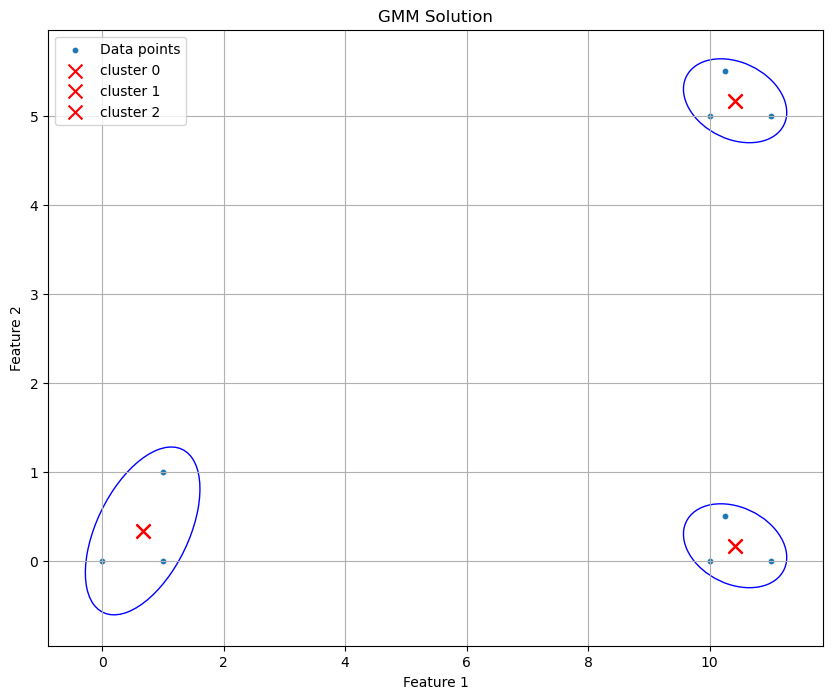

In [20]:
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
              [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
worked1 = False
worked2 = False
for _ in range(10):
    pi, mu, sigma, _ = em_gmm(X, k=3)
    print(f"mu is {mu}")
    print(sigma.shape)
    print(sigma)
    print(mu[0])

    # test one cluster center
    if (np.linalg.norm(mu[0] - [10.41666, 0.1666]) < 0.1 or
        np.linalg.norm(mu[1] - [10.41666, 0.1666]) < 0.1 or
        np.linalg.norm(mu[2] - [10.41666, 0.1666]) < 0.1):
        worked1 = True
    if ((np.abs(np.linalg.det(sigma[0]) - 0.03703) < 0.001 or
           np.abs(np.linalg.det(sigma[1]) - 0.03703) < 0.001 or
           np.abs(np.linalg.det(sigma[2]) - 0.03703) < 0.001) and
           (np.abs(np.linalg.det(sigma[0]) - 0.00925) < 0.001 or
           np.abs(np.linalg.det(sigma[1]) - 0.00925) < 0.0001 or
           np.abs(np.linalg.det(sigma[2]) - 0.00925) < 0.0001)):
        worked2 = True
    if worked1 and worked2:
        plot_gmm_solution(X, mu, sigma)
        break

if not worked1:
    raise AssertionError('test_em_gmm did not find the correct cluster center.')
if not worked2:
    raise AssertionError('test_em_gmm did not find the correct cluster center.')


In [21]:
# For Visualization of GMM in Abgabe
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def norm_pdf(X, mean, cov):
    return multivariate_normal.pdf(X, mean=mean, cov=cov, allow_singular=True)

def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-3):
    """ Implements EM for Gaussian Mixture Models
        Input:
        X: (n x d) data matrix
        k: number of clusters
        max_iter: maximum number of iterations
        init_kmeans: whether kmeans should be used for initialisation
        tol: when log likelihood difference is smaller than tol, terminate loop
        
        Output:
        pi: 1 x k matrix of priors
        mu: (k x d) matrix with each cluster center in one column
        sigma: list of d x d covariance matrices
        loglik: the log-likelihood after the last iteration
        g: (n x k) matrix of responsibilities
    """
    n, d = np.shape(X)
    if init_kmeans:
        print('Init by k-means ')
        mu, _, _ = kmeans(X, k=k)
        mu = np.asmatrix(mu)
    else:
        print('Init by random and without k-means ')
        rand_row = np.random.randint(low=0, high=n, size=k)
        mu = np.asmatrix([X[row_idx, :] for row_idx in rand_row])
    sigma = np.array([np.eye(d) for _ in range(k)])
    pi = np.ones(k) / k
    g = np.full((n, k), fill_value=1 / k)  # gamma

    logLik = 1.0
    prev_logLik = 0

    iteration = 0
    while abs(logLik - prev_logLik) > tol and iteration < max_iter:
        prev_logLik = logLik

        # E-step --> Bayes Rule to compute the posterior probability of each component given the data point
        logLik = 0
        for j in range(k):
            pdf = norm_pdf(X, np.ravel(mu[j, :]), sigma[j, :])
            g[:, j] = pdf * pi[j]
        logLik = np.sum(np.log(g.sum(axis=1)))
        g /= g.sum(axis=1, keepdims=True)

        # M Step
        for j in range(k):
            nk = g[:, j].sum()
            pi[j] = nk / n

            mu[j] = (X * g[:, j][:, np.newaxis]).sum(axis=0) / nk
            sigma_j = np.zeros((d, d))
            for i in range(n):
                diff = (X[i, :] - mu[j]).T
                sigma_j += g[i, j] * np.outer(diff, diff)
            sigma[j] = sigma_j / nk
            
        iteration += 1
        print('Iter:{},  log-likelihood:{}'.format(iteration, logLik))
    print('Finished at {} Iter, Log-likelihood:{}'.format(iteration, logLik))
    
    return pi, mu, sigma, logLik, g

def plot_gmm_solution(X, mu, sigma, g):
    clusters = np.argmax(g, axis=1)
    plt.figure(figsize=(8, 6))
    
    #colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#33FFF3', '#FFBF33', '#8E44AD']
    for i in range(np.max(clusters) + 1):
        cluster_points = X[clusters == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {i}')
        plot_cov_ellipse(sigma[i,:], mu[i,:])
        
    plt.scatter(np.ravel(mu[:, 0]), np.ravel(mu[:, 1]), color='black', marker='x', s=100, label='Centroids')
    plt.title(f'GMM Clustering for 5 Gaussians with k = {i+1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

def plot_cov_ellipse(cov, mu, nstd=2, **kwargs):
    """
    Plots an ellipse representing the covariance matrix.
    """
    # Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    vx, vy = eigvecs[:,0]
    theta = np.degrees(np.arctan2(vy, vx))
    
    # Width and height of ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)

    u = mu[0, 0]  # x-position center
    v = mu[0, 1]  # y-position center
    
    # Plotting the ellipse
    ellipse = Ellipse(xy=(u,v), width=width, height=height, angle=theta)
    ellipse.set_facecolor('none')
    edgecolor = kwargs.get('edgecolor', 'blue')
    ellipse.set_edgecolor(edgecolor)
    plt.gca().add_patch(ellipse)





In [23]:
X = np.load('data/5_gaussians.npy')

In [24]:
print("Shape of the dataset:", X.shape)

Shape of the dataset: (2, 500)


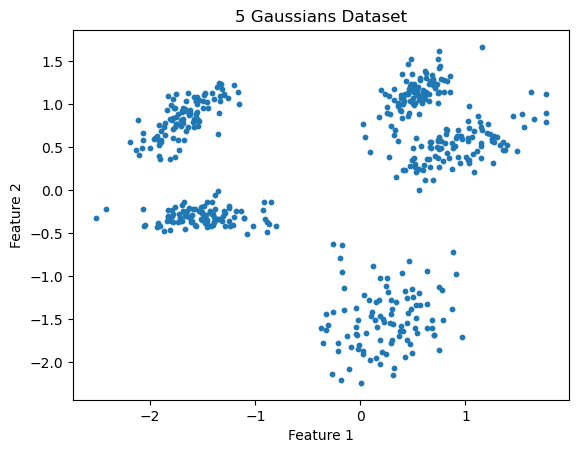

In [25]:
plt.scatter(X[0,:], X[1,:], s=10)
plt.title('5 Gaussians Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Init by random and without k-means 
Iter:1,  log-likelihood:-1587.0252657400913
Iter:2,  log-likelihood:-1272.3769217245333
Iter:3,  log-likelihood:-1179.7225260888445
Iter:4,  log-likelihood:-1146.2837870116175
Iter:5,  log-likelihood:-1144.014756720308
Iter:6,  log-likelihood:-1144.0020906692312
Iter:7,  log-likelihood:-1144.0020592728865
Iter:8,  log-likelihood:-1144.002059174636
Finished at 8 Iter, Log-likelihood:-1144.002059174636


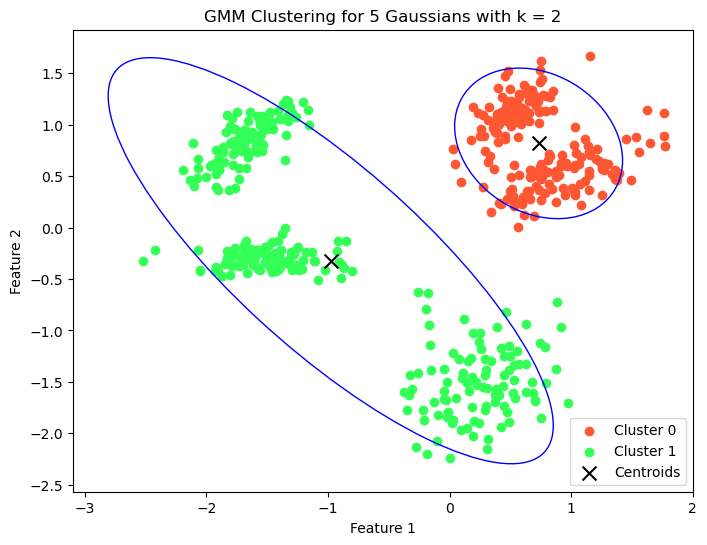

In [26]:
pi, mu, sigma, loglik, g = em_gmm(X.T, k=2, max_iter=100, init_kmeans=False, tol=1e-5)
plot_gmm_solution(X.T, mu, sigma,g)

Init by k-means 
Iter:1,  log-likelihood:-1487.7371281561395
Iter:2,  log-likelihood:-1347.104626662698
Iter:3,  log-likelihood:-1211.2964337967046
Iter:4,  log-likelihood:-1148.4518103292262
Iter:5,  log-likelihood:-1144.0380200695868
Iter:6,  log-likelihood:-1144.0021461537272
Iter:7,  log-likelihood:-1144.0020594418781
Iter:8,  log-likelihood:-1144.0020591751845
Finished at 8 Iter, Log-likelihood:-1144.0020591751845


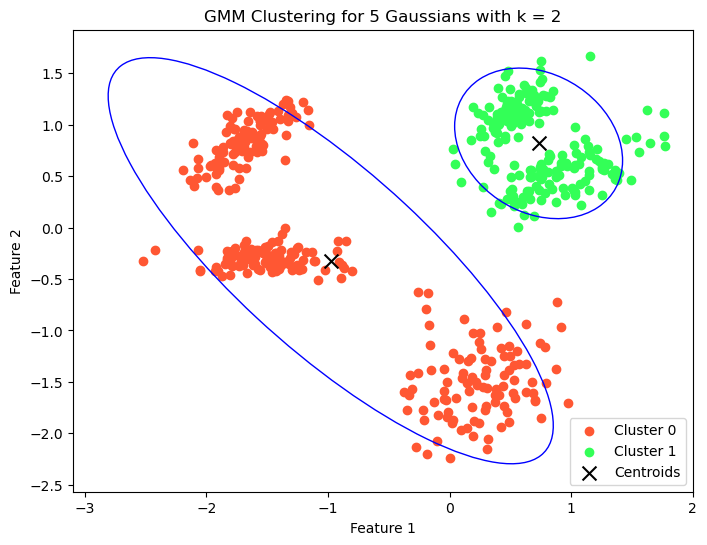

Init by k-means 
Iter:1,  log-likelihood:-1479.7160973221007
Iter:2,  log-likelihood:-1212.1720791947578
Iter:3,  log-likelihood:-988.6705068071245
Iter:4,  log-likelihood:-955.0865744746061
Iter:5,  log-likelihood:-954.19848563838
Iter:6,  log-likelihood:-954.198402340314
Iter:7,  log-likelihood:-954.1984023327461
Finished at 7 Iter, Log-likelihood:-954.1984023327461


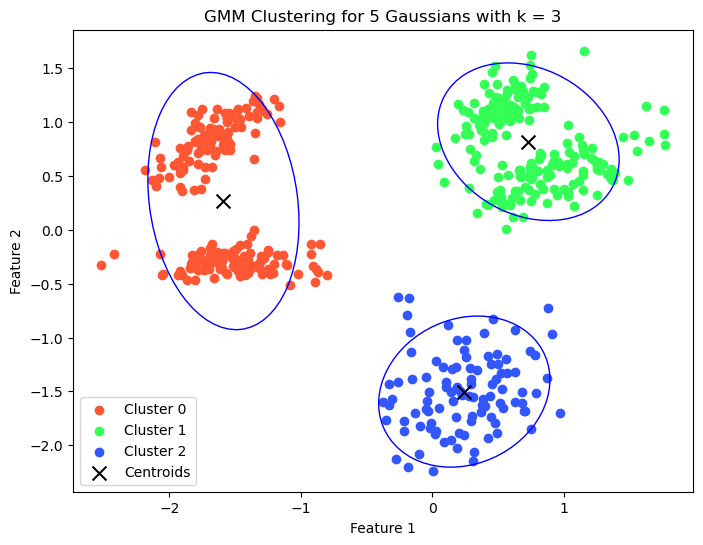

Init by k-means 
Iter:1,  log-likelihood:-1501.6673709546506
Iter:2,  log-likelihood:-1213.4897968848986
Iter:3,  log-likelihood:-1008.4019635601298
Iter:4,  log-likelihood:-948.7813636973319
Iter:5,  log-likelihood:-943.1494478467879
Iter:6,  log-likelihood:-936.8550057065332
Iter:7,  log-likelihood:-926.0074068700974
Iter:8,  log-likelihood:-902.7957521739256
Iter:9,  log-likelihood:-843.2521700726853
Iter:10,  log-likelihood:-765.2501990563994
Iter:11,  log-likelihood:-759.3318825899944
Iter:12,  log-likelihood:-759.3314460784854
Iter:13,  log-likelihood:-759.331446074199
Finished at 13 Iter, Log-likelihood:-759.331446074199


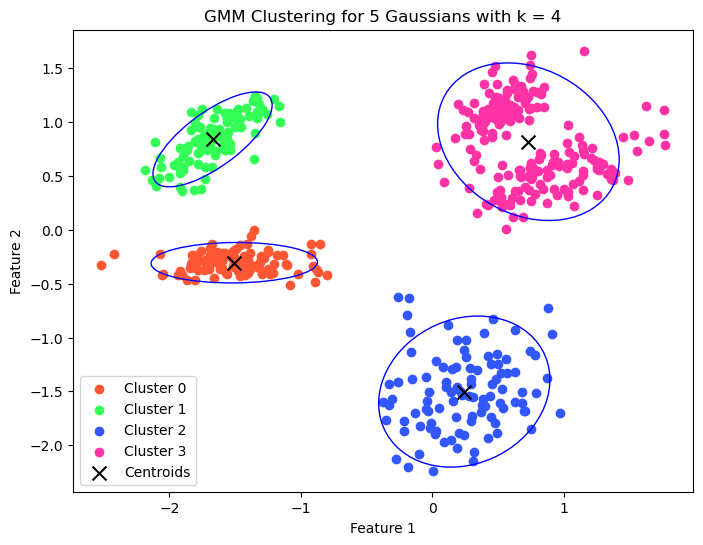

Init by k-means 
Iter:1,  log-likelihood:-1488.3476103411433
Iter:2,  log-likelihood:-1217.447295335999
Iter:3,  log-likelihood:-987.1767965686996
Iter:4,  log-likelihood:-944.3905791214968
Iter:5,  log-likelihood:-937.1227932500095
Iter:6,  log-likelihood:-926.2565194742195
Iter:7,  log-likelihood:-906.9024332517555
Iter:8,  log-likelihood:-864.3706919342927
Iter:9,  log-likelihood:-779.4131765086106
Iter:10,  log-likelihood:-743.2298619879211
Iter:11,  log-likelihood:-740.7031185512808
Iter:12,  log-likelihood:-738.4063492401867
Iter:13,  log-likelihood:-736.039095048978
Iter:14,  log-likelihood:-733.3353915514831
Iter:15,  log-likelihood:-729.7032536838379
Iter:16,  log-likelihood:-723.665628836946
Iter:17,  log-likelihood:-711.2938463850184
Iter:18,  log-likelihood:-690.9333585467616
Iter:19,  log-likelihood:-672.9372732558224
Iter:20,  log-likelihood:-667.3541317769598
Iter:21,  log-likelihood:-666.8201111574901
Iter:22,  log-likelihood:-666.7246292894524
Iter:23,  log-likelihood:

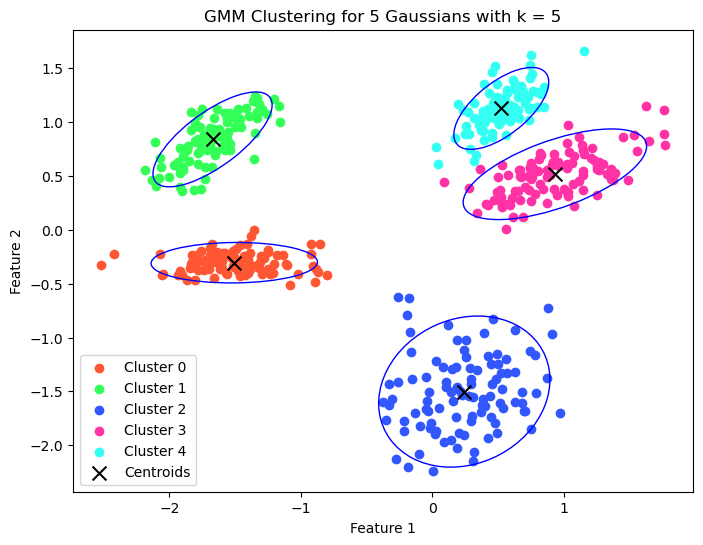

Init by k-means 
Iter:1,  log-likelihood:-1495.903531436047
Iter:2,  log-likelihood:-1216.1303822885452
Iter:3,  log-likelihood:-996.2692634042361
Iter:4,  log-likelihood:-947.0479206205945
Iter:5,  log-likelihood:-938.0056900217843
Iter:6,  log-likelihood:-926.8680235931479
Iter:7,  log-likelihood:-906.1826550975559
Iter:8,  log-likelihood:-861.5081632740128
Iter:9,  log-likelihood:-792.8944952989843
Iter:10,  log-likelihood:-762.9036830712872
Iter:11,  log-likelihood:-749.3832834711882
Iter:12,  log-likelihood:-743.5157399168428
Iter:13,  log-likelihood:-739.5176881019379
Iter:14,  log-likelihood:-736.1234774895664
Iter:15,  log-likelihood:-732.726739647441
Iter:16,  log-likelihood:-728.5989497319633
Iter:17,  log-likelihood:-722.359373339706
Iter:18,  log-likelihood:-710.3868380960562
Iter:19,  log-likelihood:-689.7522372334475
Iter:20,  log-likelihood:-670.58745945433
Iter:21,  log-likelihood:-664.4347994113848
Iter:22,  log-likelihood:-663.7820562694408
Iter:23,  log-likelihood:-6

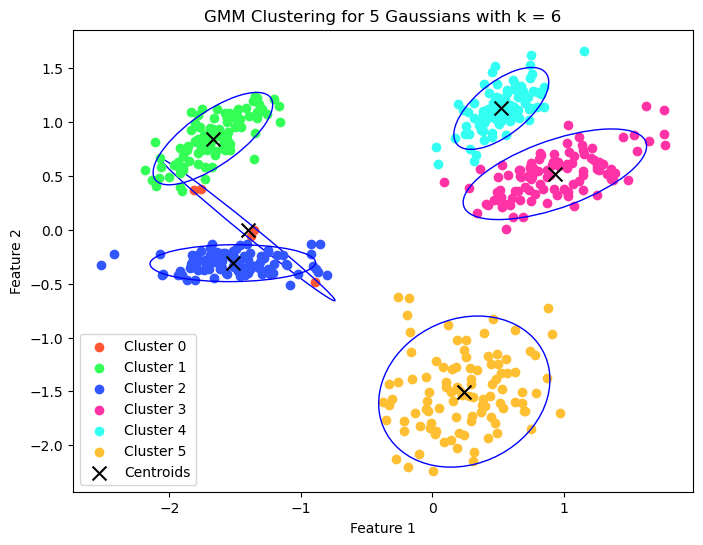

Init by k-means 
Iter:1,  log-likelihood:-1500.1884231582853
Iter:2,  log-likelihood:-1229.419110446654
Iter:3,  log-likelihood:-1012.7637368472249
Iter:4,  log-likelihood:-951.3504097965495
Iter:5,  log-likelihood:-939.1994466551953
Iter:6,  log-likelihood:-928.0947946827191
Iter:7,  log-likelihood:-908.6636428026923
Iter:8,  log-likelihood:-866.2709314276503
Iter:9,  log-likelihood:-793.6581606740829
Iter:10,  log-likelihood:-758.8969439200848
Iter:11,  log-likelihood:-745.944565241377
Iter:12,  log-likelihood:-739.413094650708
Iter:13,  log-likelihood:-735.0893999952289
Iter:14,  log-likelihood:-731.5528312281564
Iter:15,  log-likelihood:-728.2027249478906
Iter:16,  log-likelihood:-724.5228375167535
Iter:17,  log-likelihood:-719.6597543329052
Iter:18,  log-likelihood:-711.5379158783287
Iter:19,  log-likelihood:-695.6355733733624
Iter:20,  log-likelihood:-674.3740021277988
Iter:21,  log-likelihood:-660.0268379580875
Iter:22,  log-likelihood:-657.2697828600149
Iter:23,  log-likelihood

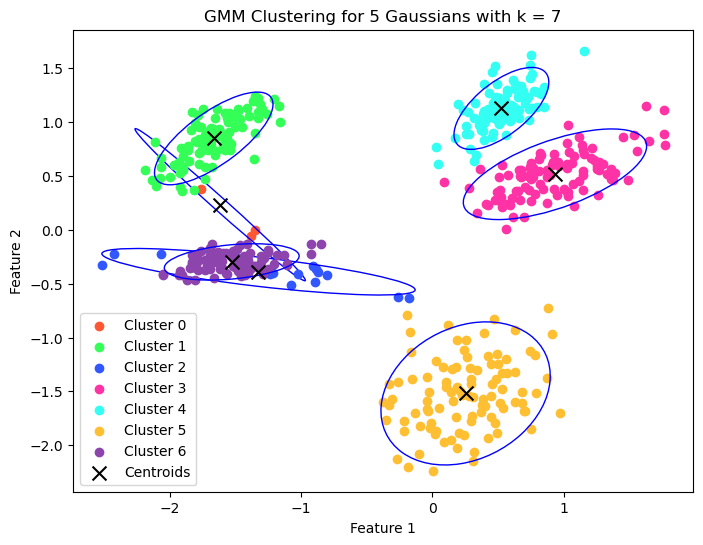

In [27]:
#np.random.seed(42)
for k in range(2,8):
    pi, mu, sigma, loglik,g = em_gmm(X.T, k=k, max_iter=100, init_kmeans=True, tol=1e-5)
    plot_gmm_solution(X.T, mu, sigma,g)

5 Gaussians shape: (2, 500)


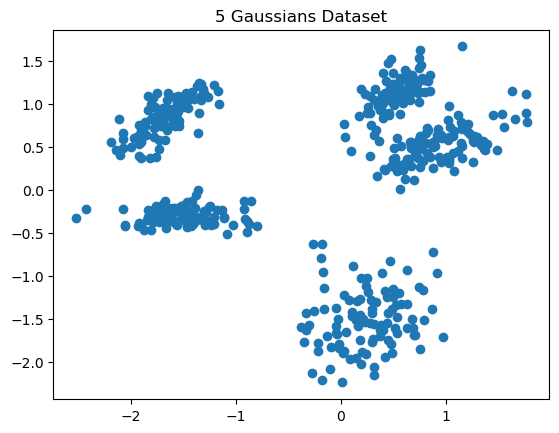

2 Gaussians shape: (2, 200)


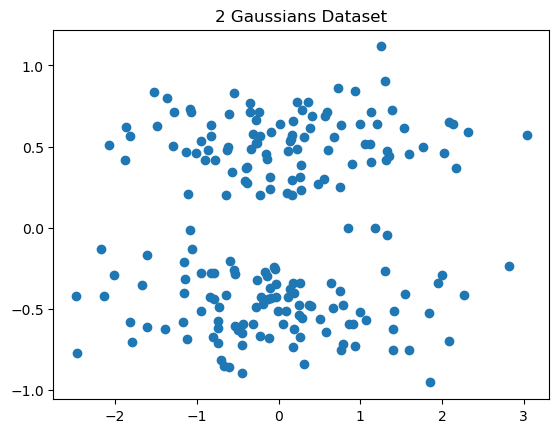

Lab Data shape: (3, 1000)


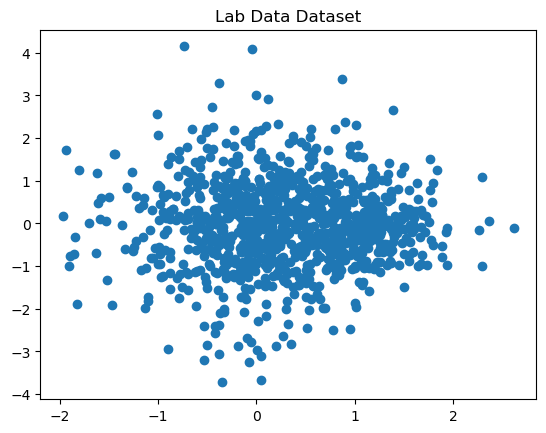


Analyzing 5 Gaussians Dataset
Analyzing k = 2 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


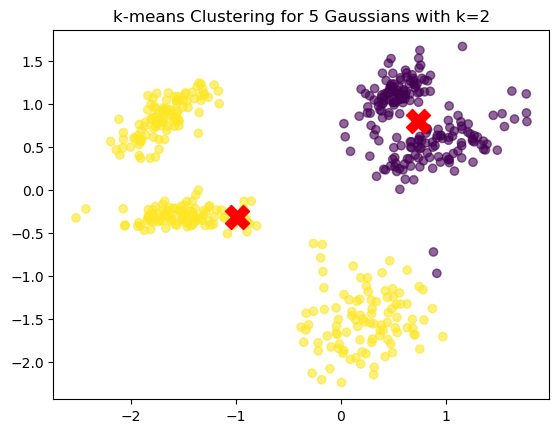

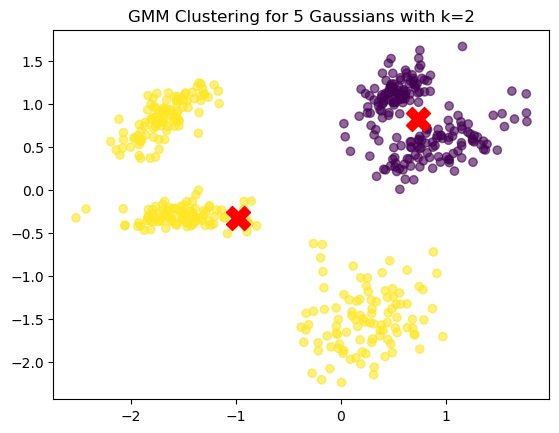

Analyzing k = 3 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


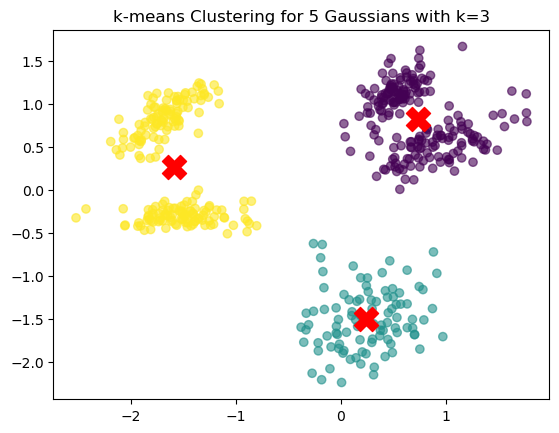

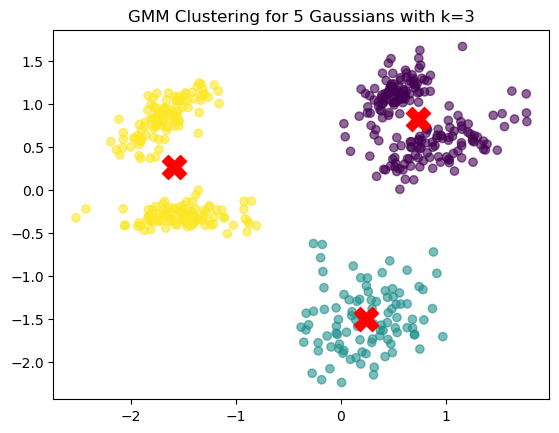

Analyzing k = 4 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


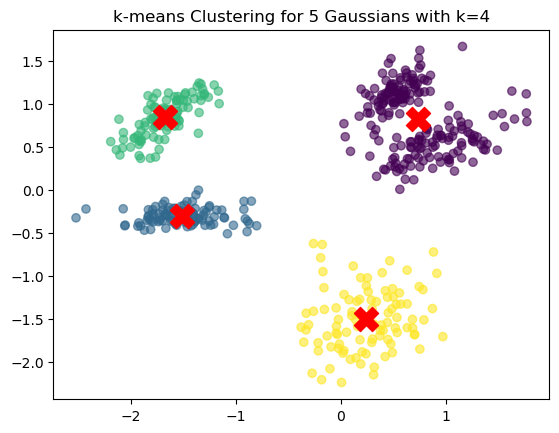

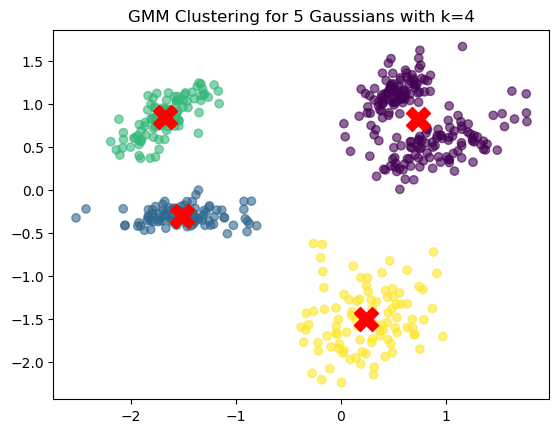

Analyzing k = 5 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


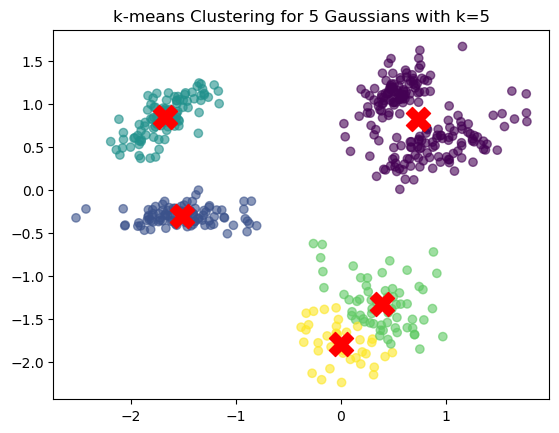

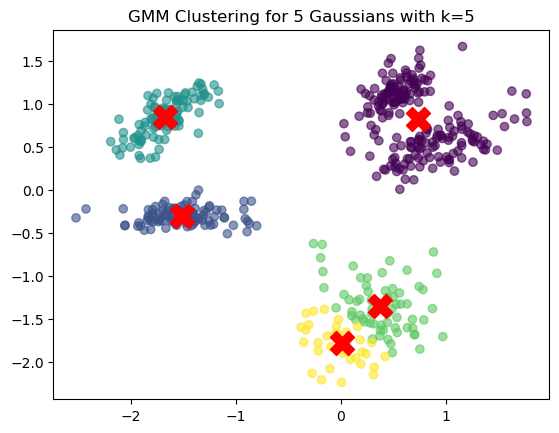

Analyzing k = 6 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


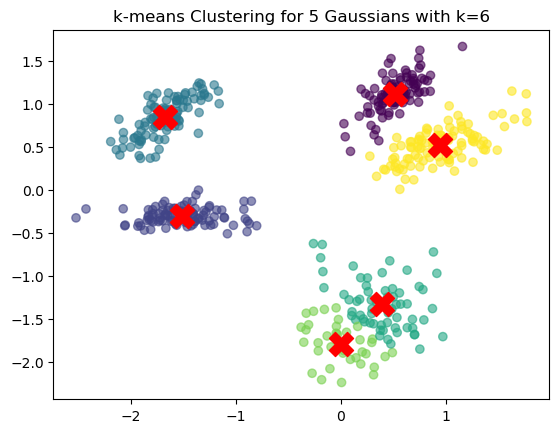

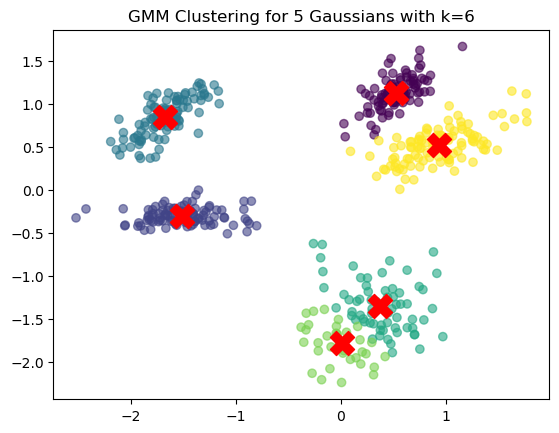

Analyzing k = 7 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


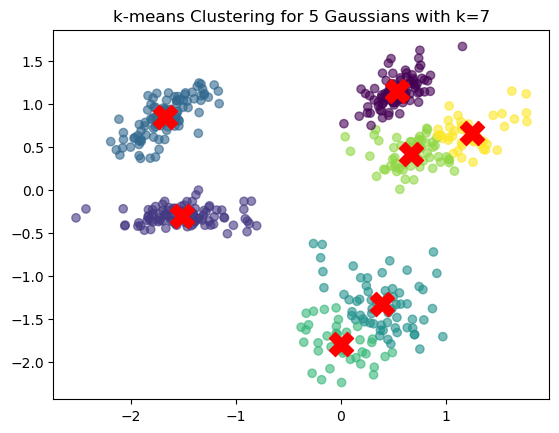

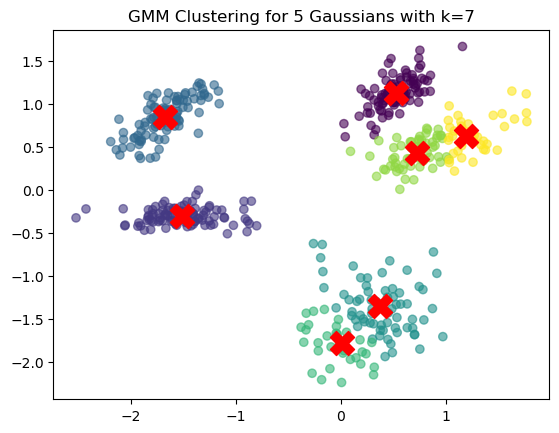

Analyzing k = 8 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


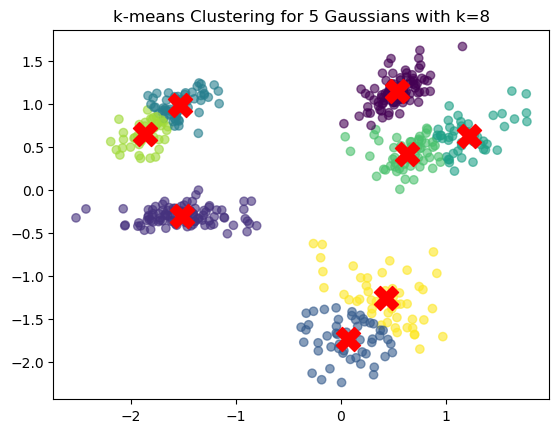

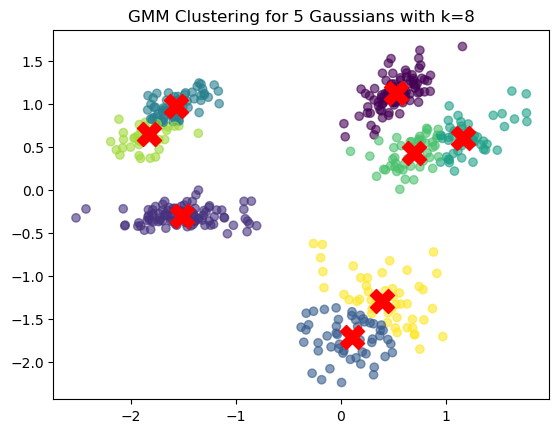

Analyzing k = 9 for 5 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


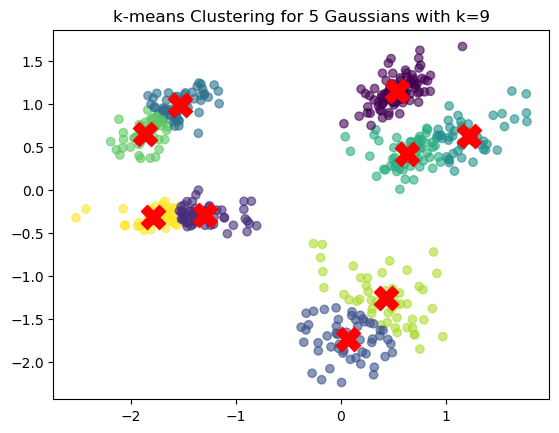

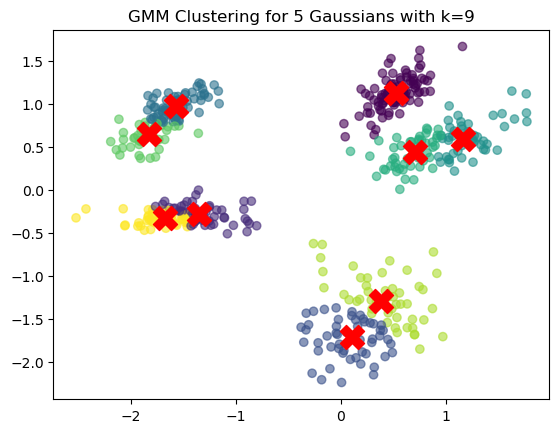

Centroids for 5 Gaussians with k=5:
[[ 0.73222541  0.81862857]
 [-1.5067663  -0.30529366]
 [-1.67221508  0.83996401]
 [ 0.39544225 -1.32502927]
 [-0.00210775 -1.79111347]]
Labels for 5 Gaussians with k=5:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

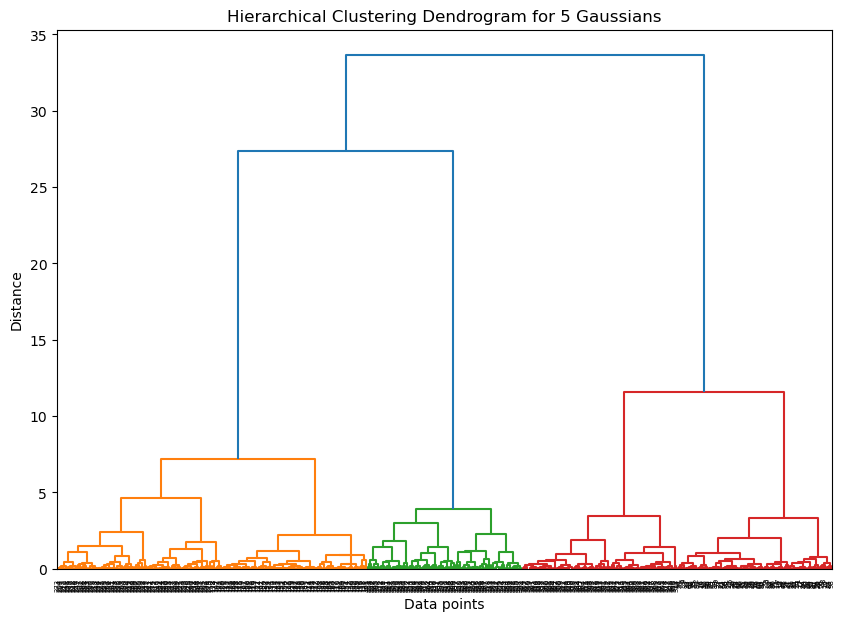


Analyzing 2 Gaussians Dataset
Analyzing k = 2 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


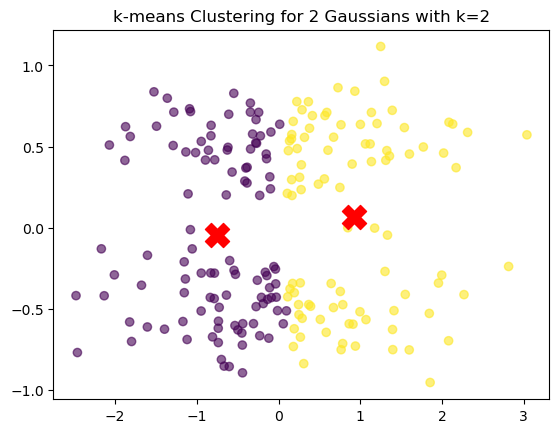

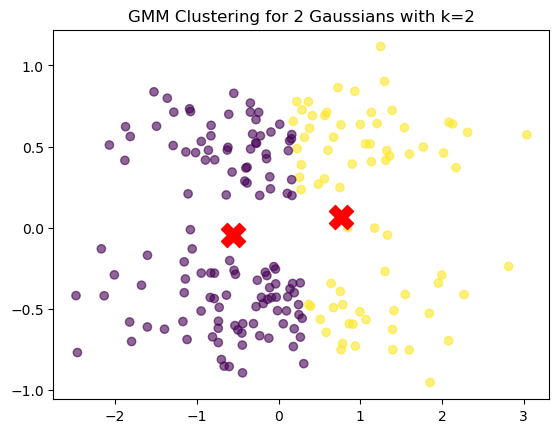

Analyzing k = 3 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


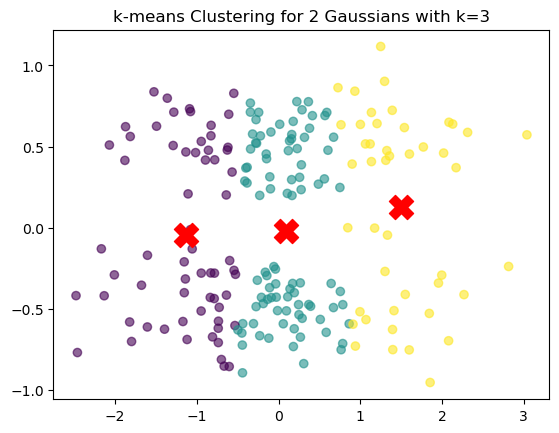

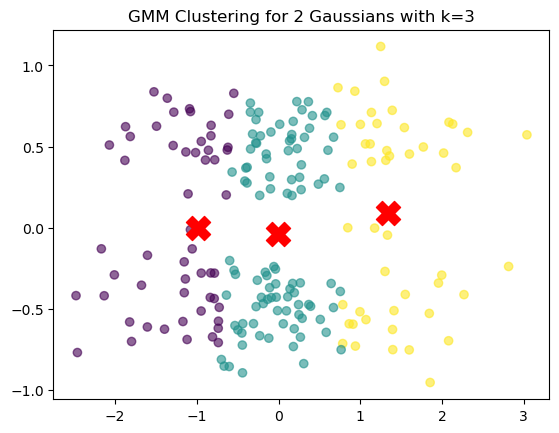

Analyzing k = 4 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


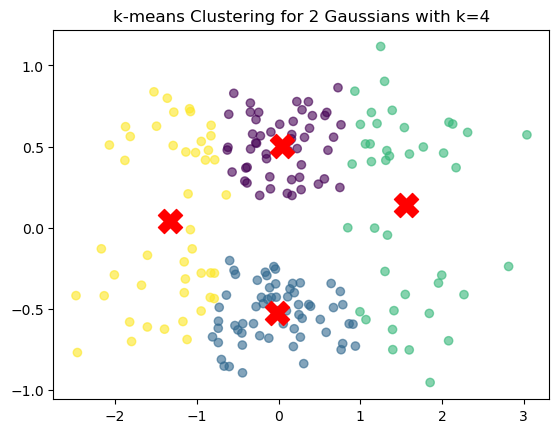

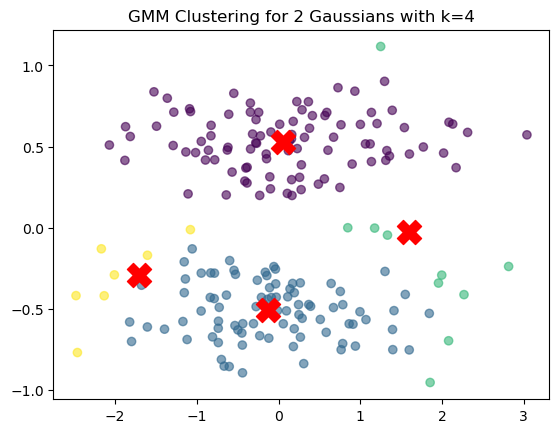

Analyzing k = 5 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


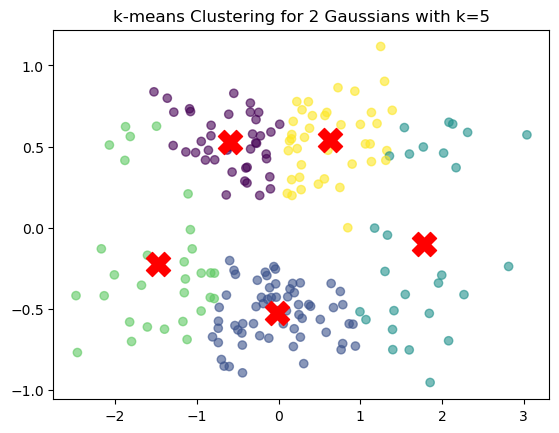

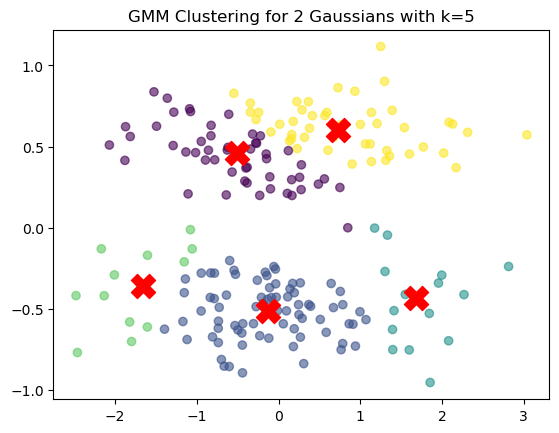

Analyzing k = 6 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


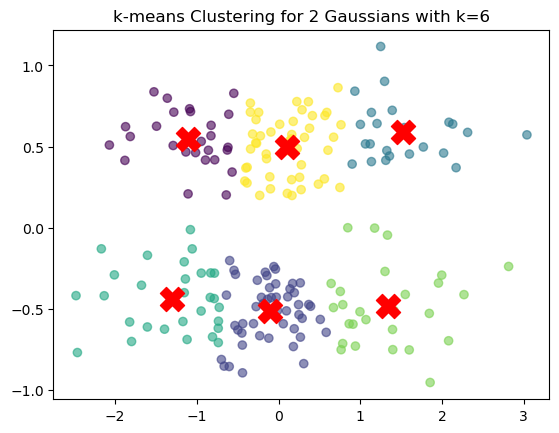

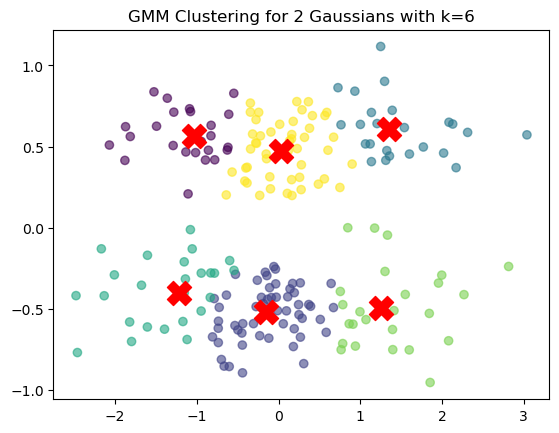

Analyzing k = 7 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


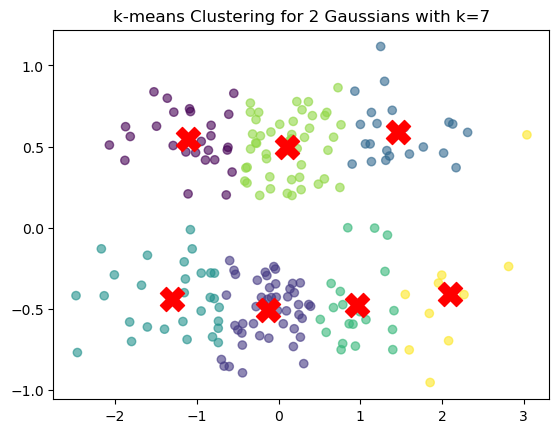

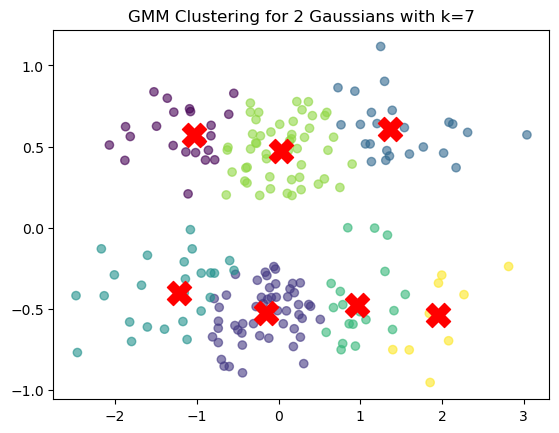

Analyzing k = 8 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


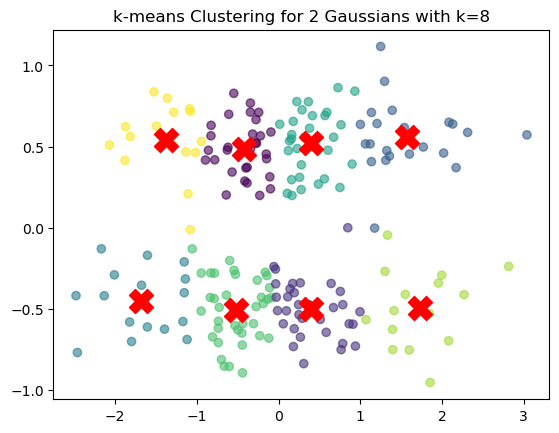

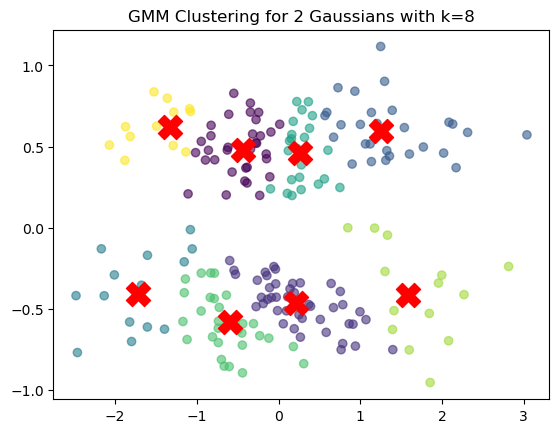

Analyzing k = 9 for 2 Gaussians


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


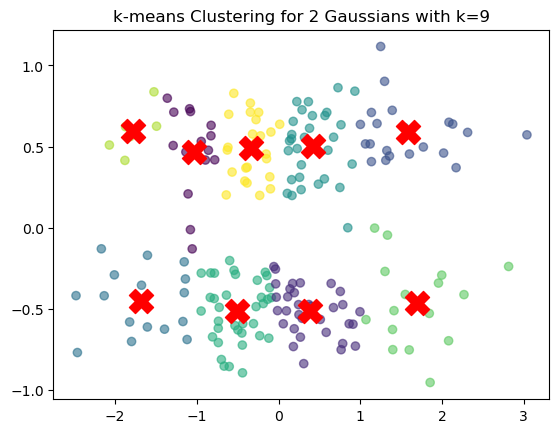

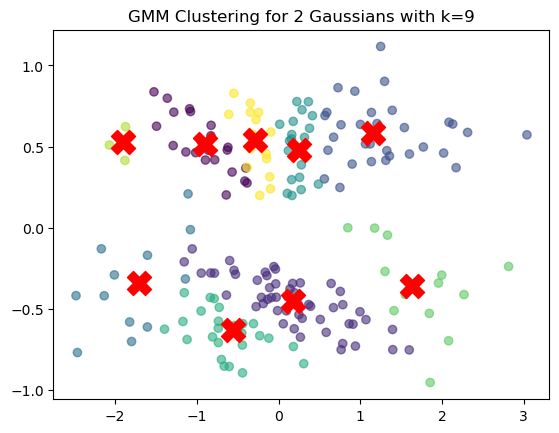

Centroids for 2 Gaussians with k=5:
[[-0.58896881  0.5251134 ]
 [-0.0239957  -0.52988668]
 [ 1.78009376 -0.09837627]
 [-1.47978569 -0.22389063]
 [ 0.63031196  0.53883962]]
Labels for 2 Gaussians with k=5:
[4 4 0 4 2 2 4 0 0 0 3 0 0 0 4 4 0 4 0 4 2 0 0 4 0 4 2 2 4 0 0 0 4 0 0 4 0
 2 0 4 4 4 4 0 4 4 0 4 3 4 4 4 4 2 0 0 4 3 0 4 3 4 0 0 0 4 0 4 0 0 0 4 3 4
 0 0 2 0 2 4 2 4 4 4 2 4 4 0 0 3 4 4 2 0 0 0 4 3 0 4 1 1 1 1 1 1 1 2 1 2 1
 3 1 1 2 3 2 3 3 3 3 2 1 1 1 3 1 2 2 3 1 1 3 1 3 1 1 1 1 1 2 2 3 1 1 1 3 1
 3 1 1 1 1 1 1 1 1 1 2 1 1 3 1 1 1 1 1 2 1 1 2 1 3 3 1 3 1 3 1 1 3 2 1 2 1
 1 1 1 1 2 3 3 1 3 1 3 1 1 1 1]
Inertia for 2 Gaussians with k=5: 59.20757227158223
Means for 2 Gaussians with k=5:
[[-0.50459014  0.45950955]
 [-0.13059799 -0.51681573]
 [ 1.67566037 -0.43752608]
 [-1.65736745 -0.36202076]
 [ 0.73166169  0.59973693]]
Covariances for 2 Gaussians with k=5:
[[[ 0.5140802  -0.06155903]
  [-0.06155903  0.03272755]]

 [[ 0.47073429 -0.01048333]
  [-0.01048333  0.02951715]]

 [[ 0.27077479

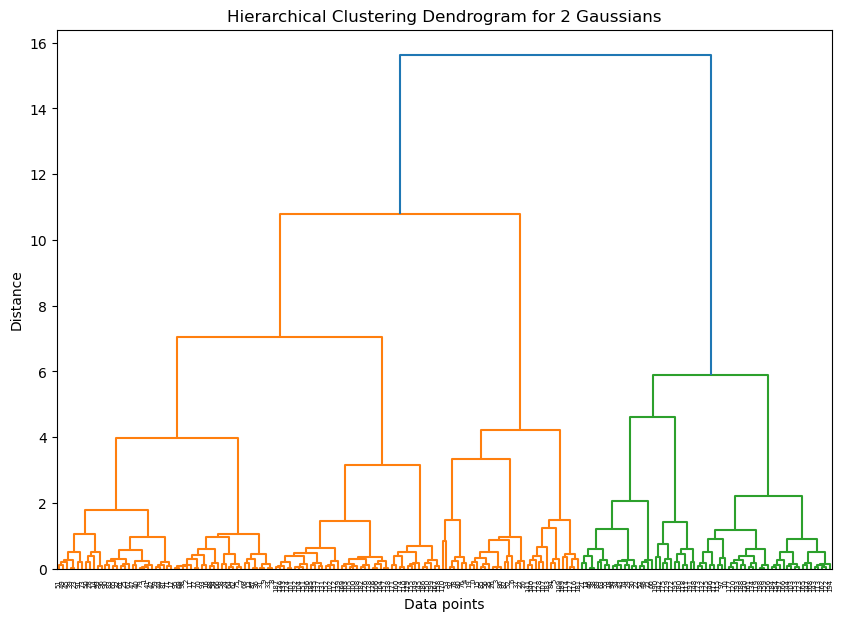


Analyzing Lab Data Dataset
Analyzing k = 2 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


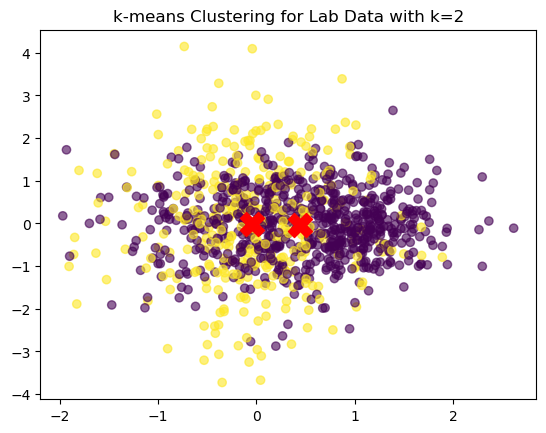

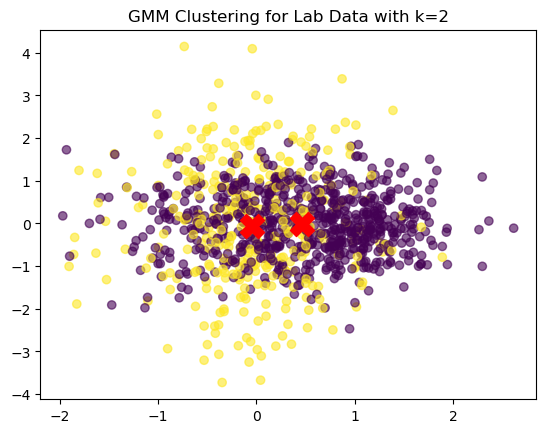

Analyzing k = 3 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


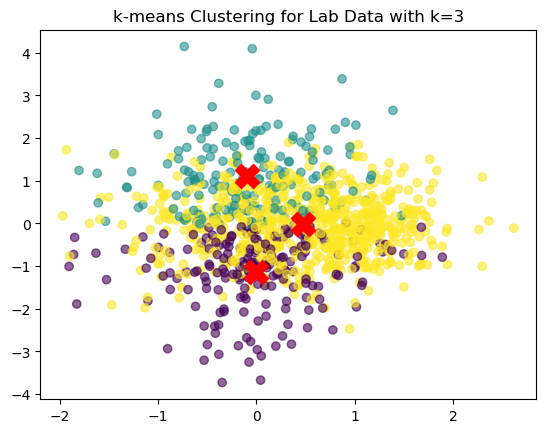

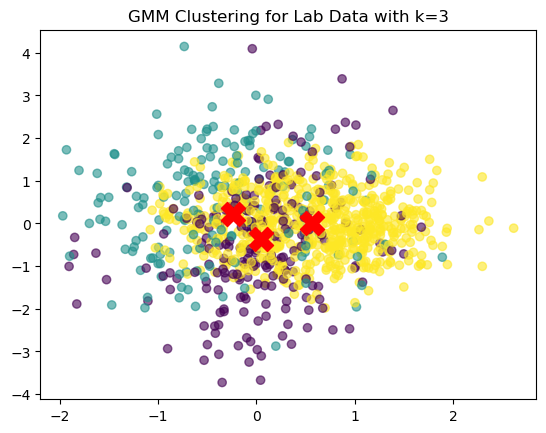

Analyzing k = 4 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


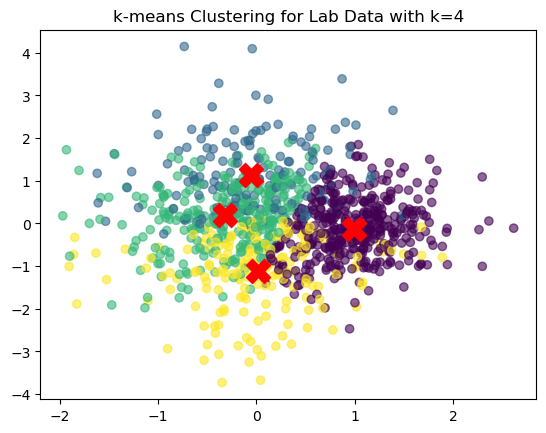

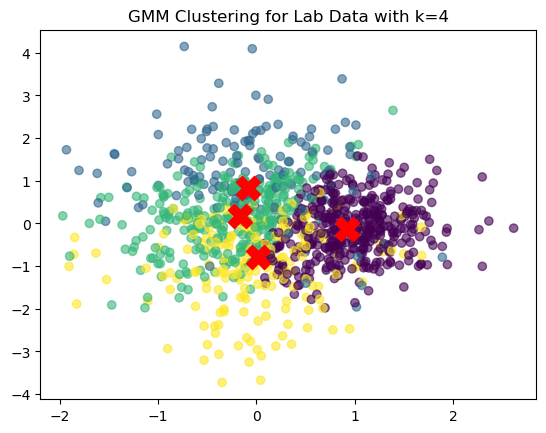

Analyzing k = 5 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


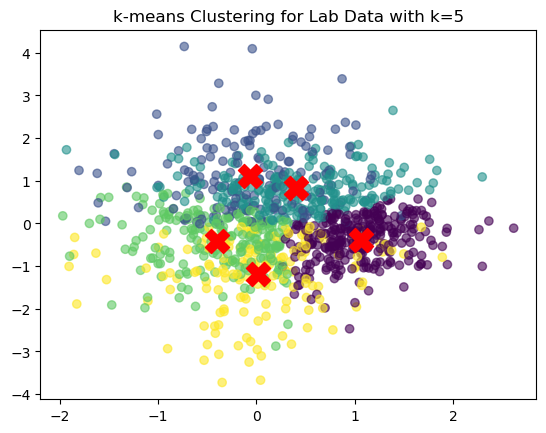

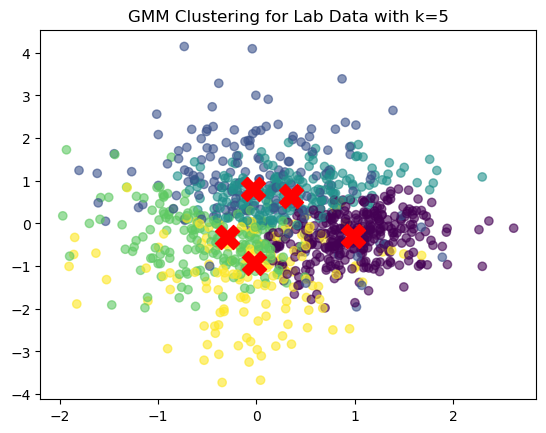

Analyzing k = 6 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


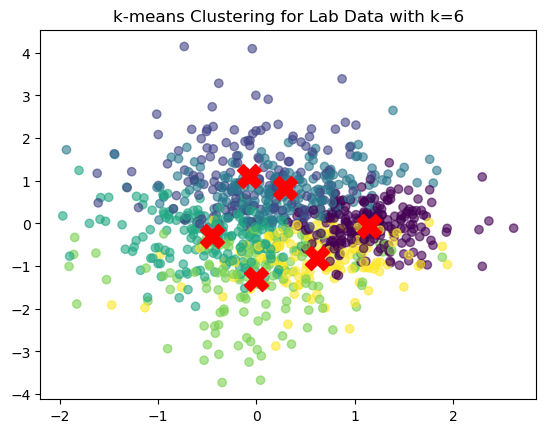

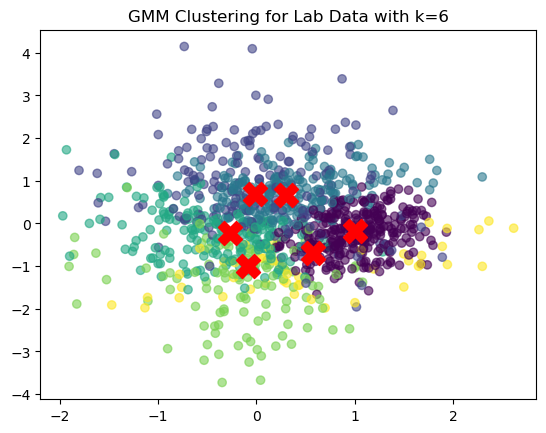

Analyzing k = 7 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


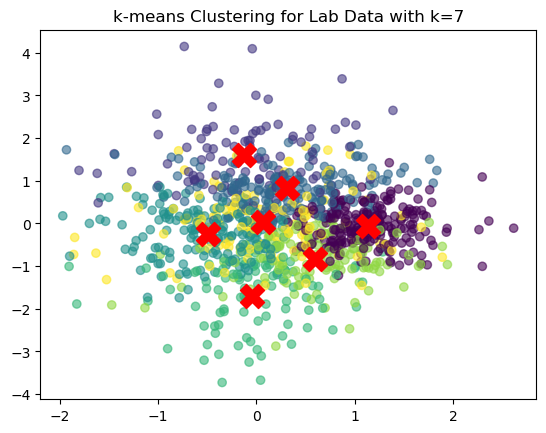

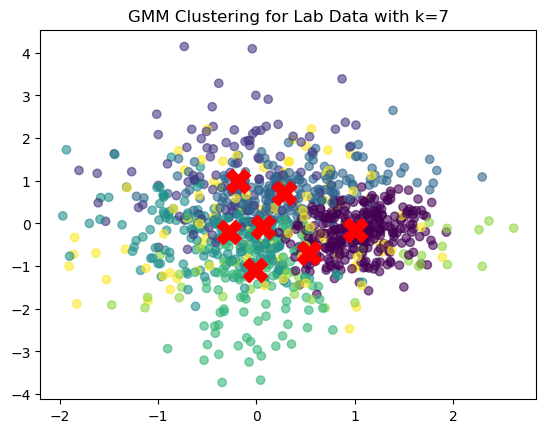

Analyzing k = 8 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


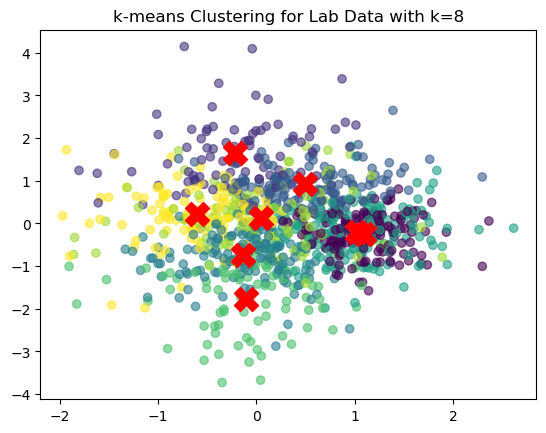

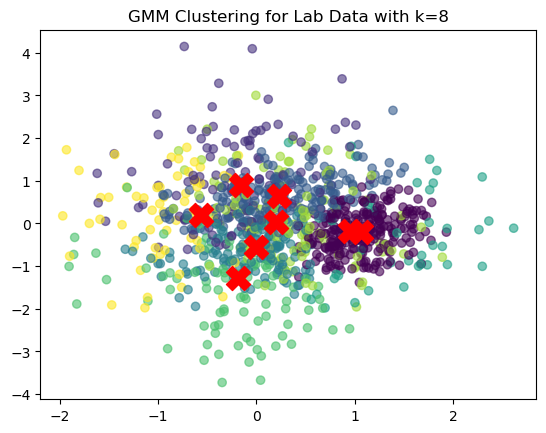

Analyzing k = 9 for Lab Data


c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ufuka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


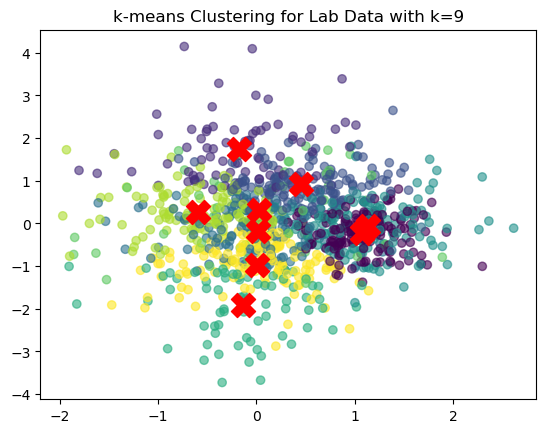

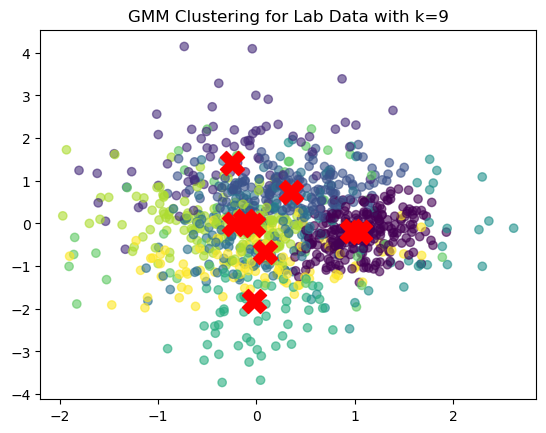

Centroids for Lab Data with k=5:
[[ 1.06219644 -0.38692321  1.01733409]
 [-0.06609691  1.10215859 -1.32729438]
 [ 0.40580286  0.8253791   1.11477485]
 [-0.39577615 -0.41143796  0.84480561]
 [ 0.01398742 -1.18944136 -1.32082244]]
Labels for Lab Data with k=5:
[0 1 1 4 2 2 1 2 4 4 0 1 1 2 0 4 4 3 0 0 4 0 0 2 1 3 2 1 0 0 4 3 0 4 0 3 3
 4 0 0 2 2 4 4 2 0 2 2 0 0 1 0 1 2 0 3 3 0 3 1 2 1 1 3 4 1 4 1 1 0 4 3 1 0
 4 0 2 0 0 2 3 0 1 0 3 1 0 0 1 0 4 4 3 2 1 1 0 3 1 1 2 3 1 4 4 4 0 3 3 0 4
 3 4 2 0 2 0 4 3 2 0 1 4 3 0 2 0 0 1 0 3 4 4 4 0 0 3 0 4 0 2 3 3 1 2 4 2 4
 4 3 4 0 4 3 0 1 3 2 1 4 1 0 2 3 3 0 1 1 0 0 2 2 1 4 0 4 1 3 3 1 1 1 2 1 0
 2 0 1 0 0 3 2 3 0 2 0 3 3 0 0 4 2 4 0 3 3 0 3 0 3 4 4 0 4 1 3 1 0 2 4 2 0
 3 1 3 3 2 3 4 4 4 1 2 0 0 4 1 3 4 3 4 0 2 2 2 2 1 1 4 0 1 3 0 3 3 0 0 4 3
 3 2 0 3 1 3 0 0 2 0 0 0 1 2 0 1 2 0 2 4 4 1 0 3 0 0 2 0 3 0 0 1 4 3 0 2 0
 0 4 3 2 3 0 3 2 0 4 0 2 2 0 1 2 4 0 2 2 0 0 4 3 3 4 4 0 2 4 2 1 0 0 3 2 0
 0 2 3 1 3 2 0 0 4 0 1 3 2 4 1 2 1 1 1 4 2 2 3 1 0 0 2 2 1 1 3 2 3

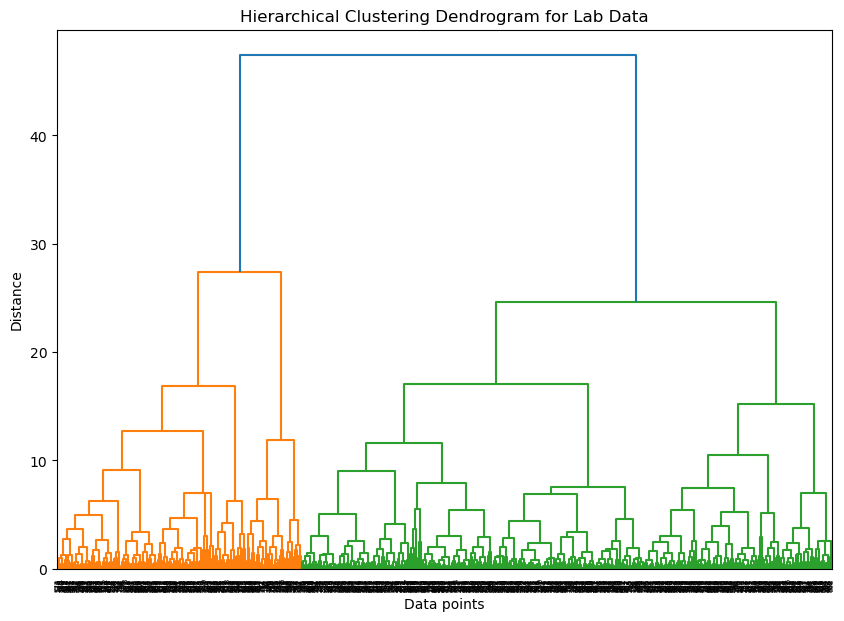

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Load datasets
data_5_gaussians = np.load("data/5_gaussians.npy")
data_2_gaussians = np.load("data/2_gaussians.npy")
lab_data = np.load("data/lab_data.npz")
lab_data_X = lab_data['X'].T
lab_data_Y = lab_data['Y'].T

k_range = range(2, 10)
kmeans_results = {}
gmm_results = {}

datasets = {
    "5 Gaussians": data_5_gaussians,
    "2 Gaussians": data_2_gaussians,
    "Lab Data": lab_data_X,
}

# Inspect datasets
for name, data in datasets.items():
    print(f"{name} shape: {data.shape}")
    if data.shape[1] < max(k_range):
        print(f"Warning: {name} has less samples than the maximum number of clusters")
    plt.figure()
    plt.scatter(data[0], data[1])
    plt.title(f"{name} Dataset")
    plt.show()

for name, data in datasets.items():
    print(f"\nAnalyzing {name} Dataset")

    kmeans_results[name] = {}
    gmm_results[name] = {}

    for k in k_range:
        if data.shape[1] >= k:
            print(f"Analyzing k = {k} for {name}")
            kmeans = KMeans(n_clusters=k, random_state=42).fit(data.T)
            kmeans_results[name][k] = (kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_)

            gmm = GaussianMixture(n_components=k, random_state=42).fit(data.T)
            labels = gmm.predict(data.T)
            means = gmm.means_
            covariances = gmm.covariances_
            weights = gmm.weights_
            log_likelihood = gmm.lower_bound_
            gmm_results[name][k] = (means, covariances, weights, labels, log_likelihood)

            plt.figure()
            plt.scatter(data[0], data[1], c=kmeans.labels_, cmap='viridis', marker='o', alpha=0.6)
            plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
            plt.title(f"k-means Clustering for {name} with k={k}")
            plt.show()

            plt.figure()
            plt.scatter(data[0], data[1], c=labels, cmap='viridis', marker='o', alpha=0.6)
            plt.scatter(means[:, 0], means[:, 1], s=300, c='red', marker='X')
            plt.title(f"GMM Clustering for {name} with k={k}")
            plt.show()

    # Example output for k=5 if it exists
    if 5 in kmeans_results[name]:
        centroids, labels, inertia = kmeans_results[name][5]
        print(f"Centroids for {name} with k=5:\n{centroids}")
        print(f"Labels for {name} with k=5:\n{labels}")
        print(f"Inertia for {name} with k=5: {inertia}")

    if 5 in gmm_results[name]:
        means, covariances, weights, labels, log_likelihood = gmm_results[name][5]
        print(f"Means for {name} with k=5:\n{means}")
        print(f"Covariances for {name} with k=5:\n{covariances}")
        print(f"Weights for {name} with k=5:\n{weights}")
        print(f"Labels for {name} with k=5:\n{labels}")
        print(f"Log likelihood for {name} with k=5: {log_likelihood}")

    if data.shape[1] > 1:
        linked = linkage(data.T, 'ward')
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Hierarchical Clustering Dendrogram for {name}")
        plt.xlabel("Data points")
        plt.ylabel("Distance")
        plt.show()


In [30]:
import scipy.io
usps = scipy.io.loadmat('data/usps.mat')
usps=usps['data_patterns'].T
usps.shape

(2007, 256)

K-Means cluster centers:
[[ 0.00000000e+00 -3.35016487e-01 -8.70540934e-01 -8.71657484e-01
   8.21054277e-02  7.56386297e-01  2.69818600e+00  5.30682066e+00
  -5.90775571e-02 -6.24009262e-01 -8.45451789e-01  6.08733555e-01
  -2.04828041e-01 -1.22703931e-01  3.32473705e+00  6.63542845e+00
  -4.46250733e-02 -6.06444536e-01  4.04559613e-02  1.67883652e-01
  -9.39088384e-01  3.12570504e-02  3.56293250e+00  4.90316302e+00
  -3.33797263e-02 -6.45350139e-02  3.46035739e-01 -3.04020506e-01
  -4.05465525e-01  1.16083857e+00  1.55990338e+00  2.07468239e+00
   0.00000000e+00  4.61416273e-02  1.47522944e-01 -6.46469565e-02
   2.30123046e-01  8.33072741e-01  1.29336768e-01  0.00000000e+00
  -6.13436689e-02 -3.74736366e-01 -6.75445390e-01 -3.61538519e-01
   6.75603100e-01 -1.11786409e-01 -6.98189395e-01 -8.87416172e-02
  -3.54332626e-02 -4.03574986e-01 -1.26535245e+00 -4.73173597e-01
   4.81158802e-01 -1.02139660e+00 -7.57435810e-01 -2.09785127e-01
  -2.35964589e-02 -2.99081347e-01 -8.47628833e-01 -

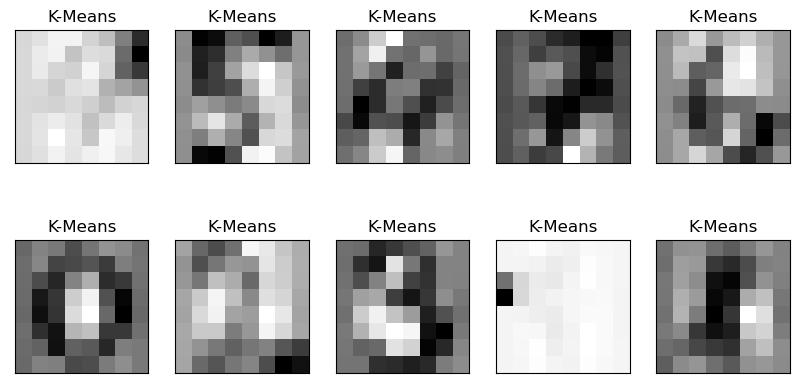

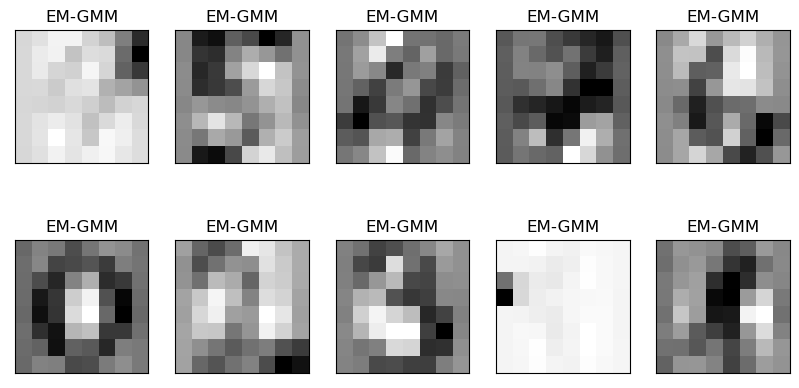

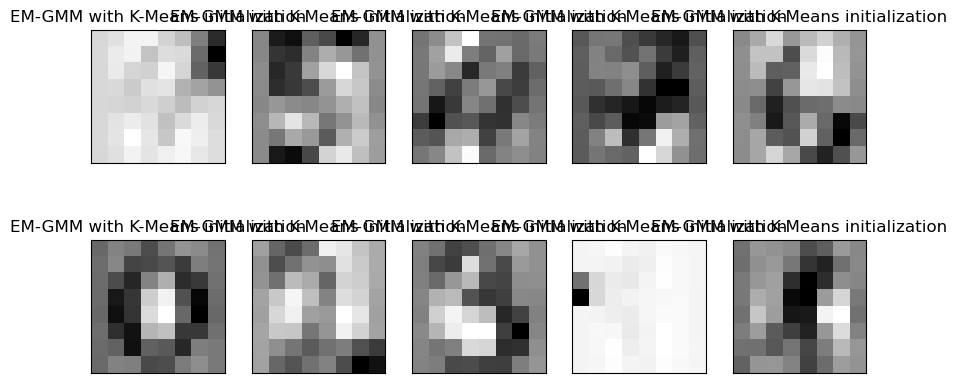

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 1: Load the USPS dataset
digits = load_digits()
X = digits.data
y = digits.target

# Step 2: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_scaled)

# Step 4: Apply EM-GMM clustering
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_scaled)

# Step 5: Apply EM-GMM with K-Means initialization
gmm_km = GaussianMixture(n_components=10, init_params='kmeans', random_state=42)
gmm_km.fit(X_scaled)

# Step 6: Compare cluster centers
print("K-Means cluster centers:")
print(kmeans.cluster_centers_)
print("\nEM-GMM cluster centers:")
print(gmm.means_)
print("\nEM-GMM with K-Means initialization cluster centers:")
print(gmm_km.means_)

# Step 7: Plot cluster centroids as images
def plot_cluster_centroids(cluster_centers, title):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})
    for ax, centroid in zip(axes.flat, cluster_centers):
        ax.imshow(centroid.reshape(8, 8), cmap='binary')
        ax.set_title(title)
    plt.show()

plot_cluster_centroids(kmeans.cluster_centers_, "K-Means")
plot_cluster_centroids(gmm.means_, "EM-GMM")
plot_cluster_centroids(gmm_km.means_, "EM-GMM with K-Means initialization")
